# Analysis of Puget Sound Hisorical Wind Speed and Direction Observations

## Motivation

As an environmental engineering PhD student I have become interested in water quality models of Puget Sound that predict how nutrients may contribute to changes in dissolved oxygen (DO) levels. The main source of nitrogen--the limiting nutrient for primary production in Puget Sound--[is the ocean (Khangaonkar et al, 2018)](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2017JC013650), but the ocean's effect is limited by hydrodynamic mixing into surface waters. To address water quality concerns the Washington Department of Ecology is currently considering limiting the allowed amount of nutrients discharged from wastewater treatment plants, and this will [entail expensive upgrades](https://kingcounty.gov/~/media/services/environment/wastewater/mwpaac/docs/2020/2020_09_23_Nutrient-Removal.ashx) that could be passed along to ratepayers in the region. Because of the amount of money at stake, it is important to get a good picture of how changes in nutrient levels could be expected to impact the Sound.

Water quality models of an estuary like Puget Sound are dependent upon a firm understanding of hydrodynamics, as currents and tides are incredibly important for transport and mixing processes. One key variable is the wind, which can influence mixing. Water quality models often use one or more nearby airports with automated surface wind observations, but [an airport does not always have the same wind conditions as the water body being modeled]. Puget Sound, in particular, is a large system which has multiple wind observation locations scattered around it. Through an analysis of available wind data, I hope to discover how winds in Puget Sound vary with location and time, then assess whether the modeled years of 2006, 2014 and 2016 experienced winds that are a good representation of the types of wind conditions in the historical record. I also hope to identify significant gaps in the observational record that could introduce uncertainty when this data is used in a model of Puget Sound. In the future I hope to build on this investigation with a wind sensitivity analysis of the Salish Sea Model, basing my design on how I determine the winds tend to vary in reality.

## Background

Surface winds over Puget Sound and offshore have a variety of forcing effects. Winds strongly influence upwelling off the coast, which affects water temperatures, salinity and nutrients. The prevailing winds tend to be related to long-term climate variability through phenomena like the [El Niño Southern Oscillation (ENSO)](https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php) and the [Pacific Decadal Oscillation (PDO)](https://www.ncdc.noaa.gov/teleconnections/pdo/). There are also short-term effects of winds, like storm events changing the prevailing wind direction. ([Moore et al, 2008](https://doi.org/10.4319/lo.2008.53.5.1746))

The Salish Sea Model (SSM) is a recently developed hydrodynamic and water quality model of the Puget Sound with a model domain that extends over the entire Salish Sea, the Strait of Juan de Fuca, and the Pacific continental shelf as far north as the Strait of Georgia and south to the Columbia River mouth. The model has been calibrated to run under conditions from three different years: 2006, 2014, and 2016. The goal is to develop a model that is able to predict water quality parameters under various scenarios (such as freshwater discharges and future climate conditions) to inform policy decisions. Environmental models are simply idealized representations of a natural system, and while they cannot be truly verified, they can be used to identify potentially important aspects of the system using sensitivity analyses ([Oreskes et al, 1994](https://doi.org/10.1126/science.263.5147.641)). The SSM has not been thoroughly evaluated for its sensitivity to winds.

## Data

I intend to pull wind observations from the [Integrated Surface Database (ISD)](https://www.ncdc.noaa.gov/isd), a dataset published by NOAA's National Centers for Environmental Information (formerly the National Climate Data Center). The ISD-Lite dataset, in particular, contains simplified hourly observations of wind speed and direction from 35,000 stations worldwide (many of them airports), about 20 of which are located around Puget Sound. Some stations have data going as far back as 1901, though data going back this far is sparse and very few stations are represented. Analysis in a separate notebook, FetchClimateData.ipynb, showed that 15 stations have been producing observations with relatively few gaps since 2008. Going back farther requires narrowing the list of stations to six, but it is then possible to begin the analysis in 1975.

This analysis looks at datasets built from both subsets of the ISD-Lite record: a "recent/dense" record of 16 stations from 2008 to 2020, and a "long run" record of six stations from 1975 to 2020. The data were fetched and cleaned up using the notebook FetchClimateData.ipynb.

While this data does not directly include observations of wind speed over the waters of Puget Sound, I believe that variability in the data may be representative of Puget Sound surface winds. The Salish Sea Model itself relies on model outputs from UW's Mesoscale Analysis and Forecasting Group for wind data ([Ahmed et al, 2019](https://fortress.wa.gov/ecy/publications/SummaryPages/1903001.html)), and I believe that falling back on actual wind observations may be a better way to get a sense for how surface winds are behaving as this should sidestep any uncertainties in the underlying meteorological model.

The data from US climate stations appears to be licensed for use without restriction, although the terms are not clearly specified.

## Research Questions

* What is the historic variability in wind speed and direction in the Puget
  Sound region?
* How correlated are the reported wind speeds and directions from different
  stations along the coast, in the Strait of Juan de Fuca, etc?
* Do wind characteristics seem to correlate with major climate cycles like
  ENSO and the PDO?
* Do the SSM calibration years represent typical conditions, or are they outliers?
* Are there outlier years in the historical data with conditions which should be covered in a future sensitivity analysis?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from calendar import month_abbr
from statsmodels.tsa.seasonal import seasonal_decompose

## Methodology

Because two different data samples are being analyzed, the bulk of the analysis code is defined below in functions which accept a Pandas Dataframe as an argument.

`corrs` looks at correlations in wind speed and direction between all the stations.

In [2]:
def corrs(df):
    corrdf_spd = pd.DataFrame([])
    corrdf_dir = pd.DataFrame([])
    for name, group in df.groupby('station_id'):
        corrdf_spd['wind_speed_{0}'.format(name)] = group.set_index('date')['wind_speed']
        corrdf_dir['wind_dir_{0}'.format(name)] = group.set_index('date')['wind_dir']
    corrdf_spd = corrdf_spd.dropna(how='all')
    corrdf_dir = corrdf_dir.dropna(how='all')
    return corrdf_spd.corr(), corrdf_dir.corr()

`hists` produces histograms of wind speed and direction.

In [3]:
def hists(df):
    fig, axs = plt.subplots(1, 2, figsize=(7, 4), constrained_layout=True)
    axs[0].hist(df['wind_speed'].dropna(), bins=35)
    axs[0].set(xlabel='Wind speed (m/s)', ylabel='Counts')
    axs[1].hist(df['wind_dir'].dropna(), bins=36)
    axs[1].set(xlabel='Wind direction (degrees)')
    fig.suptitle('Histograms of Wind speed and direction')
    return fig, axs

`speed_vs_direction` produces a simple plot of wind direction on the x axis and wind speed on the y axis. This should help determine if high wind speeds are more likely to come from certain directions, though the appearance of the plot is heavily influenced by the wind direction histogram. Both should be considered in tandem, as a spike in this plot may just be related to wind being more common from that direction in general. It is still useful information for modeling, though.

In [4]:
def speed_vs_direction(df):
    fig, ax = plt.subplots()
    ax.plot(df['wind_dir'].to_numpy(), df['wind_speed'].to_numpy(), ',')
    ax.set(title="Wind speed vs direction", xlabel="Wind direction (degrees)", ylabel="Wind speed (m/s)")
    return fig, ax

`weibull_fit` attempts to fit the wind speed data to a Weibull distribution, commonly used to represent wind speeds at a single location ([Carta et al, 2008](http://dx.doi.org/10.1016/j.rser.2008.05.005)).

In [5]:
def weibull_fit(df):
    speeds = df['wind_speed'].dropna()
    speed_k, speed_loc, speed_scale = stats.weibull_min.fit(speeds)
    speed_range = np.linspace(speeds.min(), speeds.max())
    speed_pdf_weibull = stats.weibull_min.pdf(speed_range, speed_k, scale = speed_scale)

    fig, axs = plt.subplots(1, 2, figsize=(7, 4))
    axs[0].hist(speeds, bins=35, density=True, label="Histogram")
    axs[0].plot(speed_range, speed_pdf_weibull, '--', label="Weibull; $k = {0:.2f}, \lambda = {1:.2f}$".format(speed_k, speed_scale))
    axs[0].set(xlabel='Wind speed (m/s)', ylabel='Prob Density', title='Wind Speed Histogram and Weibull Fit')
    axs[0].legend()
    stats.probplot(speeds, dist=stats.weibull_min, sparams=(speed_k, speed_loc, speed_scale), plot=axs[1])
    return (speed_k, speed_loc, speed_scale), fig, axs

`gengamma_fit` is a very similar function to weibull_fit that attempts to fit wind speed data to a generalized gamma distribution. Carta et al suggests this as one possible alternative when a Weibull fit does not work well.

In [6]:
# Generalized Gamma distribution fit to wind speed
def gengamma_fit(df):
    speeds = df['wind_speed'].dropna()
    params = stats.gengamma.fit(speeds)
    speed_range = np.linspace(speeds.min(), speeds.max())
    speed_pdf_gengamma = stats.gengamma.pdf(speed_range, params[0], params[1], scale = params[3])

    fig, axs = plt.subplots(1, 2, figsize=(7, 4))
    axs[0].hist(speeds, bins=35, density=True, label="Histogram")
    axs[0].plot(speed_range, speed_pdf_gengamma, '--', label="Gen Gamma; $a = {0:.2f}, c = {1:.2f}, \lambda = {2:.2f}$".format(params[0], params[1], params[3]))
    axs[0].set(xlabel='Wind speed (m/s)', ylabel='Prob Density', title='Wind Speed Histogram and Generalized Gamma Fit')
    axs[0].legend()
    stats.probplot(speeds, dist=stats.gengamma, sparams=params, plot=axs[1])
    return params, fig, axs

`get_station_quantiles` groups all of the simultaneous station observations and produces a new DataFrame of the median and upper quartile wind speed for each time.

In [7]:
def get_station_quantiles(df, col):
    groups = df.groupby('date')
    medians = groups[col].median()
    upperquarts = groups[col].quantile(0.75)
    data = pd.DataFrame({"median": medians, "upperquart": upperquarts})
    return data

`timeseries_per_year` produces a heat map of the median and upper quartile wind speeds, with one year occupying each row. This should show seasonal patterns in the data and highlight anomalous wind conditions in specific years that deserve further investigation.

In [8]:
# time series plot of the median and upper quartile hourly wind speed
# of all stations over the course of each year (one year per series)
def timeseries_per_year(df):
    data = get_station_quantiles(df, 'wind_speed')
    data['year'] = data.index.year
    fig, axs = plt.subplots(2, 1, figsize=(18, 12))
    i = 0
    max_obs_per_year = data.groupby('year')['median'].count().max()
    medians = np.zeros([len(data['year'].unique()), max_obs_per_year])
    upperquarts = np.zeros_like(medians)
    years = []
    for year, group in data.groupby('year'):
        # Transform the datetimes so they are all in the same year, for overlay year-over-year comparison
        # Leap years are not handled properly but that's okay
        dates = (group.index - pd.to_timedelta(i*365, 'd')).to_numpy()
        m = group['median'].to_numpy()
        medians[i, :len(m)] = m
        uq = group['upperquart'].to_numpy()
        upperquarts[i, :len(m)] = uq
        i += 1
        years.append(year)
    yearticks = np.arange(0, i)
    dateticks = np.linspace(0, medians.shape[1], 13)[:-1]
    img1 = axs[0].imshow(medians, aspect='auto')
    axs[0].set(title="Median wind speed across all stations",
               yticks=yearticks, yticklabels=years, xticks=dateticks, xticklabels=month_abbr[1:])
    img2 = axs[1].imshow(upperquarts, aspect='auto')
    axs[1].set(title="Upper quartile wind speed across all stations",
               yticks=yearticks, yticklabels=years, xticks=dateticks, xticklabels=month_abbr[1:])
    fig.colorbar(img1, ax=axs[0])
    fig.colorbar(img2, ax=axs[1])
    return fig, axs

`deseasonalize` is an attempt to use a seasonal decomposition on wind speed data, which is supposed to reveal longer-term trends.

In [9]:
def deseasonalize(df, col):
    data = get_station_quantiles(df, col)
    decompose_result = seasonal_decompose(data['upperquart'], model="additive")

    fig = decompose_result.plot();
    return decompose_result, fig

`timeseries_calm` produces a time series of the daily fraction of observations of no wind.

In [10]:
calm_threshold = 1

def timeseries_calm(df):
    df = df.sort_values('date')
    df = pd.DataFrame({'date': df['date'].dt.date, 'wind_speed': df['wind_speed']})
    dates = df['date'].unique()
    groups = df.groupby('date')
    counts = np.zeros(len(dates))
    i = 0
    for d, group in groups:
        speeds = group['wind_speed'].dropna()
        counts[i] = speeds.loc[group['wind_speed'] <= calm_threshold].count() / len(speeds)
        i += 1
    fig, ax = plt.subplots()
    ax.plot(dates, counts)
    ax.set(title="Calm Wind Fraction over Time", xlabel="Year", ylabel="Calm Fraction")
    return fig, ax

`correlate` produces a scatter plot of a DataFrame column on the y axis with a climate cycle index on the x axis. No interesting patterns were found, otherwise I would have made this into a more complete regression analysis.

In [11]:
def correlate(df, col, cycleidx):
    merged = df.merge(cycleidx, left_on='date', right_index=True)
    fig, ax = plt.subplots()
    ax.plot(merged[cycleidx.columns[0]].to_numpy(), merged[col].to_numpy(), ',')
    return merged, fig, ax

`kw_by_year` performs a Kruskal-Wallis test on the wind speeds observed in each year to see if the years are subsamples of the same population or not. See, for instance, [Devore 9th ed](https://www.cengage.com/c/probability-and-statistics-for-engineering-and-the-sciences-9e-devore/9781305251809PF/).

In [12]:
def kw_by_year(df):
    df = df.copy()
    df['year'] = df['date'].dt.year
    year_speeds = [group['wind_speed'].dropna() for name, group in df.groupby('year')]
    return stats.kruskal(*year_speeds)

### Read ENSO index

Load the ENSO index from the CSV.

In [13]:
enso_file = "data/enso_history.csv"
enso_raw = pd.read_csv(enso_file, index_col=[0])
enso_raw

,DJF,JFM,FMA,MAM,AMJ,MJJ,JJA,JAS,ASO,SON,OND,NDJ
Year,,,,,,,,,,,,
1950,-1.5,-1.3,-1.2,-1.2,-1.1,-0.9,-0.5,-0.4,-0.4,-0.4,-0.6,-0.8
1951,-0.8,-0.5,-0.2,0.2,0.4,0.6,0.7,0.9,1.0,1.2,1.0,0.8
1952,0.5,0.4,0.3,0.3,0.2,0.0,-0.1,0.0,0.2,0.1,0.0,0.1
1953,0.4,0.6,0.6,0.7,0.8,0.8,0.7,0.7,0.8,0.8,0.8,0.8
1954,0.8,0.5,0.0,-0.4,-0.5,-0.5,-0.6,-0.8,-0.9,-0.8,-0.7,-0.7
...,...,...,...,...,...,...,...,...,...,...,...,...
2017,-0.3,-0.2,0.1,0.2,0.3,0.3,0.1,-0.1,-0.4,-0.7,-0.8,-1.0
2018,-0.9,-0.9,-0.7,-0.5,-0.2,0.0,0.1,0.2,0.5,0.8,0.9,0.8
2019,0.7,0.7,0.7,0.7,0.5,0.5,0.3,0.1,0.2,0.3,0.5,0.5


The raw data contains one year's worth of ONIs per row, with one month per column (the months are actually three-month rolling averages). Clean this up so we have a DataFrame of ONIs indexed by date (halfway through the middle month).

In [14]:
enso_dates = []
enso_onis = []
for i,row in enso_raw.iterrows():
    year = i
    for month,oni in enumerate(row):
        if pd.isna(oni):
            continue
        # There are only 28 days in most Februaries, so use the 14th for Feb
        enso_dates.append(pd.Timestamp(year, month + 1, 14 if month == 1 else 15))
        enso_onis.append(oni)
oni = pd.DataFrame({"oni": enso_onis}, index=pd.DatetimeIndex(enso_dates))
oni.head()

,oni
1950-01-15,-1.5
1950-02-14,-1.3
1950-03-15,-1.2
1950-04-15,-1.2
1950-05-15,-1.1


Reindex the dataframe at an hourly interval so it matches the ISD-Lite data, and interpolate the ONI so we can merge with wind speed data. Method borrowed from [this Stack Overflow answer](https://stackoverflow.com/a/30056642).

In [15]:
oni_full = oni.reindex(pd.date_range(start=oni.index.min(), end=oni.index.max(), freq='1H'))
oni_full = oni_full.interpolate(method='linear')
oni_full.head()

,oni
1950-01-15 00:00:00,-1.500000
1950-01-15 01:00:00,-1.499722
1950-01-15 02:00:00,-1.499444
1950-01-15 03:00:00,-1.499167
1950-01-15 04:00:00,-1.498889


### Read PDO index

The PDO Index source file is in much better condition, so no cleanup is necessary other than parsing the year/month into a date at the midpoint of that month.

In [16]:
pdo_file = "data/pdo_history.csv"
pdo = pd.read_csv(pdo_file, index_col=[0], parse_dates=[0], skiprows = 1,
                  date_parser = lambda col: pd.Timestamp(int(col[:4]), int(col[4:]), 14 if int(col[4:]) == 2 else 15) )
pdo = pdo.rename(columns={"Value": "pdo_index"}, copy=False)
pdo.head()

,pdo_index
Date,
1854-01-15,0.11
1854-02-14,-0.24
1854-03-15,-0.40
1854-04-15,-0.44
1854-05-15,-0.54


Just like with ONI, reindex and interpolate to the same hourly interval as wind observations

In [17]:
pdo_full = pdo.reindex(pd.date_range(start=pdo.index.min(), end=pdo.index.max(), freq='1H'))
pdo_full = pdo_full.interpolate(method='linear')
pdo_full.head()

,pdo_index
1854-01-15 00:00:00,0.110000
1854-01-15 01:00:00,0.109514
1854-01-15 02:00:00,0.109028
1854-01-15 03:00:00,0.108542
1854-01-15 04:00:00,0.108056


## Results

### The Recent/Dense Dataset

Load the dataset.

In [18]:
recentdense = pd.read_hdf("data/climate_data_recentdense2008.h5", 'recentdense', parse_dates=[1])
recentdense.head()

,station_id,date,temp,dewpt,slp_hpa,wind_dir,wind_speed,skycond,precip_1hr,precip_6hr
17335,727970-94240,2017-01-01 00:00:00,4.4,2.8,1011.9,NaN,3.1,8.0,NaN,6.0
17336,727970-94240,2017-01-01 01:00:00,3.3,1.1,1011.3,290.0,4.1,NaN,-0.1,NaN
17337,727970-94240,2017-01-01 02:00:00,3.9,1.7,1010.3,290.0,4.1,4.0,0.0,NaN
17338,727970-94240,2017-01-01 03:00:00,3.9,1.1,1009.3,290.0,4.6,NaN,0.0,NaN
17339,727970-94240,2017-01-01 04:00:00,3.3,1.1,1008.1,280.0,2.6,0.0,0.0,NaN


Load the list of recent/dense stations.

In [19]:
recentdense_stations = pd.read_csv("met_stations_recentdense.csv", index_col=0)
recentdense_stations.head()

,Name
ISD number,
727935-24234,Boeing Field
727976-24217,Bellingham Airport
720749-24255,Whidbey Airport
727923-94225,Hoquiam Airport
727970-94240,Quillayute Airport


Start with histograms of wind speed and direction.

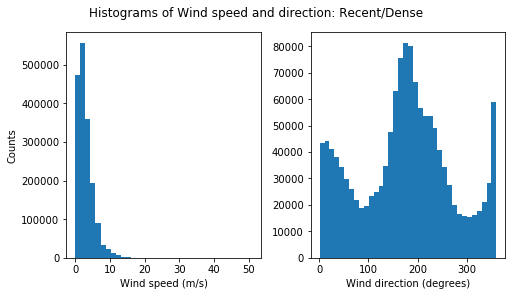

In [20]:
fig, axs = hists(recentdense)
fig.suptitle("Histograms of Wind speed and direction: Recent/Dense")
fig.savefig("figures/recentdense_hists.png")

Wind speed looks like a typical wind speed distribution, somewhat logarithmic. Wind direction shows that north and south winds dominate, though it is interesting how both spikes are so asymmetric.

Examine if the stations are correlated with each other:

In [21]:
recentdense_corrs = corrs(recentdense)
recentdense_corrs[0]

,wind_speed_714735-99999,wind_speed_717850-99999,wind_speed_719140-99999,wind_speed_720749-24255,wind_speed_722208-04224,wind_speed_727920-24227,wind_speed_727923-94225,wind_speed_727925-94227,wind_speed_727928-94263,wind_speed_727930-24233,wind_speed_727935-24234,wind_speed_727937-24222,wind_speed_727938-94274,wind_speed_727970-94240,wind_speed_727976-24217,wind_speed_994350-99999
wind_speed_714735-99999,1.000000,0.314212,0.239211,0.344628,0.355973,0.381152,0.392501,0.516991,0.301166,0.373391,0.322125,0.216924,0.351694,0.346818,0.364306,0.194999
wind_speed_717850-99999,0.314212,1.000000,0.414129,0.526772,0.463608,0.407679,0.442703,0.220351,0.331291,0.355914,0.391650,0.468940,0.374376,0.454789,0.630316,0.368472
wind_speed_719140-99999,0.239211,0.414129,1.000000,0.290006,0.409346,0.232529,0.263612,0.123583,0.195335,0.207435,0.187121,0.227362,0.206772,0.320234,0.426407,0.218825
wind_speed_720749-24255,0.344628,0.526772,0.290006,1.000000,0.450082,0.462154,0.438391,0.238753,0.286509,0.341883,0.383698,0.476933,0.345340,0.443155,0.516469,0.369410
wind_speed_722208-04224,0.355973,0.463608,0.409346,0.450082,1.000000,0.373239,0.297573,0.279243,0.346079,0.329631,0.356182,0.386349,0.351769,0.327173,0.605620,0.367424
wind_speed_727920-24227,0.381152,0.407679,0.232529,0.462154,0.373239,1.000000,0.479335,0.530674,0.558401,0.511708,0.543333,0.493192,0.622255,0.429627,0.442968,0.485135
wind_speed_727923-94225,0.392501,0.442703,0.263612,0.438391,0.297573,0.479335,1.000000,0.390141,0.405489,0.418738,0.395432,0.439314,0.417156,0.572570,0.403171,0.348894
wind_speed_727925-94227,0.516991,0.220351,0.123583,0.238753,0.279243,0.530674,0.390141,1.000000,0.458442,0.425790,0.418342,0.295783,0.489636,0.335855,0.298874,0.264438
wind_speed_727928-94263,0.301166,0.331291,0.195335,0.286509,0.346079,0.558401,0.405489,0.458442,1.000000,0.619114,0.580759,0.548305,0.655758,0.416476,0.392839,0.656632
wind_speed_727930-24233,0.373391,0.355914,0.207435,0.341883,0.329631,0.511708,0.418738,0.425790,0.619114,1.000000,0.653646,0.492206,0.676961,0.402542,0.388756,0.591849


Correlations are pretty low, keeping in mind especially that these are R values, not R^2. Correlations above 0.6 are:

* Bellingham Airport (727976) and Orcas Island (722208)
* Bellingham Airport (727976) and White Rock, BC (717850)
* Tacoma Narrows Airport (727938) and Olympia Airport (727920)
* Tacoma Narrows Airport (727938) and Bremerton Airport (727928)
* Seatac Airport (727930) and Bremerton Airport
* West Point (994350) and Bremerton Airport
* Tacoma Narrows Airport and Seatac Airport
* West Point and Boeing Field (727935)
* West Point and Tacoma Narrows Airport

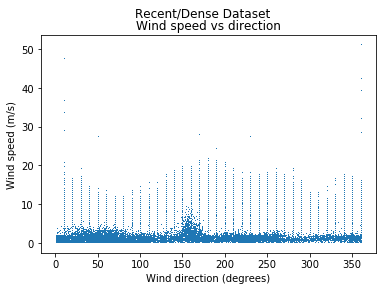

In [22]:
fig, ax = speed_vs_direction(recentdense)
fig.suptitle("Recent/Dense Dataset")
fig.savefig("figures/recentdense_speed_vs_direction.png")

It's interesting to note that the winds from the south (150-180 degrees or so) appear to be more likely to have strong winds. I also notice a slight uptick in wind speed in 30-70 degree direction.

To analyze the wind speed distribution, a good first candidate is the Weibull distribution, commonly used to characterize wind speeds at a single site ([Carta et al](http://dx.doi.org/10.1016/j.rser.2008.05.005)).

/usr/lib/python3/dist-packages/scipy/stats/_continuous_distns.py:1822: RuntimeWarning: divide by zero encountered in power
  return c*pow(x, c-1)*np.exp(-pow(x, c))


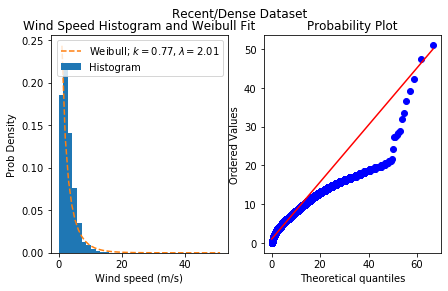

In [23]:
params, fig, axs = weibull_fit(recentdense)
fig.suptitle("Recent/Dense Dataset")
fig.savefig("figures/recentdense_weibull_fit.png")

That's not a very good fit for the middle quantiles. Carta et al also suggests the generalized gamma distribution.

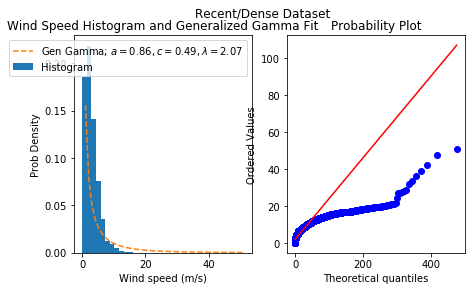

In [24]:
params, fig, axs = gengamma_fit(recentdense)
fig.suptitle("Recent/Dense Dataset")
fig.savefig("figures/recentdense_gengamma_fit.png")

This fit is quite poor. Without a good model distribution to follow, the below analysis is restricted to metrics and tests which do not make assumptions about how data is distributed.

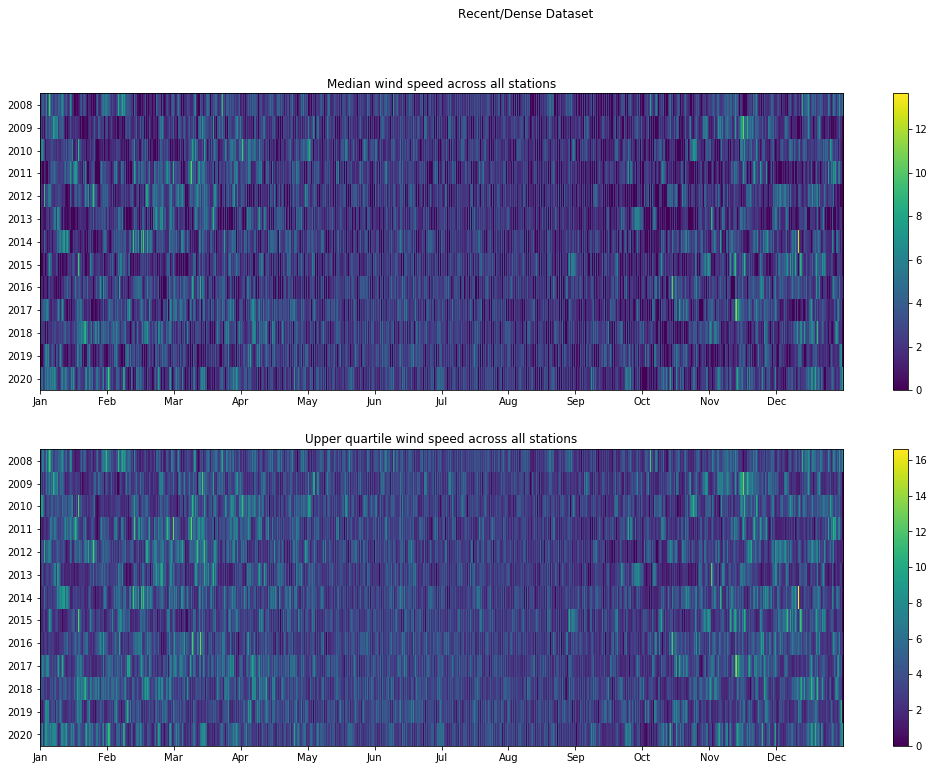

In [25]:
fig, axs = timeseries_per_year(recentdense)
fig.suptitle("Recent/Dense Dataset")
fig.savefig("figures/recentdense_timeseries_per_year.png")

These maps show that, each year, high wind conditions tend to be during the winter and spring months. In summer the wind speeds are much lower.

There is one interesting event in early September 2015, when in most other years winds are still low. I could potentially recreate these wind conditions during a modeled year to see how it responds.

There is a pretty clear seasonal trend to wind speed that should be adjusted for. I tried this:

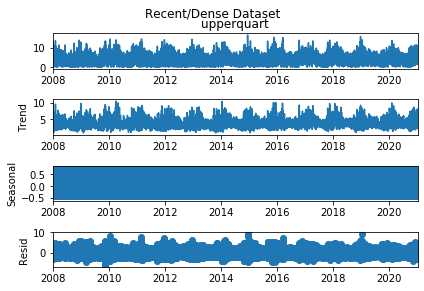

In [26]:
result, fig = deseasonalize(recentdense, 'wind_speed')
fig.suptitle("Recent/Dense Dataset", y=1.0)
fig.savefig("figures/recentdense_deseasonalize.png")

These are not good results. If it worked, "Trend" would have no annual component to it but it clearly still does. I do not have time with this analysis to troubleshoot or develop a better deseasonalization routine.

One other metric I am interested in is how often the wind speed is 0 at any given time. This analysis considers all the wind speeds recorded at all stations on a given day and produces a time series of the fraction of those observations which have zero speed.

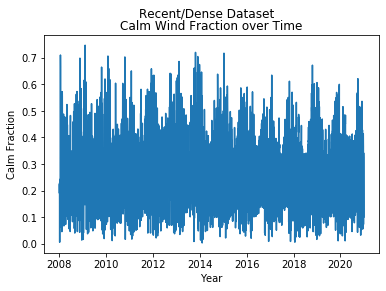

In [27]:
fig, ax = timeseries_calm(recentdense)
fig.suptitle("Recent/Dense Dataset")
fig.savefig("figures/recentdense_timeseries_calm.png")

There do not appear to be many patterns to go on here aside from the strong annual seasonal influence.

Next, perform a statistical test (Kruskal-Wallis) to see if each year of speed observations is likely a random subsample of an overall population of winds. If so, then all years are essentially interchangeable.

In [28]:
kw_by_year(recentdense)

KruskalResult(statistic=5219.476863278349, pvalue=0.0)

A p-value of 0.0 indicates that we can reject the above null hypothesis. The wind speeds in different years are independent, although the test does not tell us which years are distinct.

Is there a relationship between wind speed and El Niño?

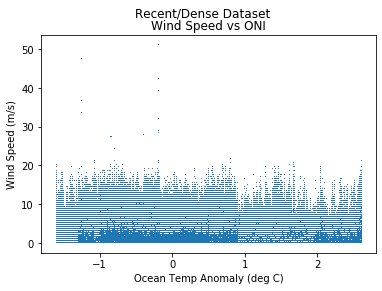

In [29]:
data, fig, ax = correlate(recentdense, 'wind_speed', oni_full)
ax.set(title="Wind Speed vs ONI", ylabel="Wind Speed (m/s)", xlabel="Ocean Temp Anomaly (deg C)")
fig.suptitle("Recent/Dense Dataset")
fig.savefig("figures/recentdense_corr_oni.png")

Visually, there does not appear to be a pattern here.

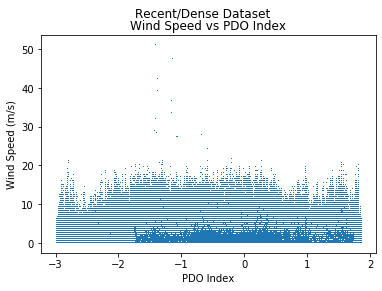

In [30]:
data, fig, ax = correlate(recentdense, 'wind_speed', pdo_full)
ax.set(title="Wind Speed vs PDO Index", xlabel="PDO Index", ylabel="Wind Speed (m/s)")
fig.suptitle("Recent/Dense Dataset")
fig.savefig("figures/recentdense_corr_pdo.png")

Similarly, there is no pattern evident.

### The Long Run Dataset

Repeat the useful analysis steps from above for the six stations identified with reliable data going back to 1975.

In [31]:
longrun = pd.read_hdf("data/climate_data_longrun1975.h5", 'longrun', parse_dates=[1])
longrun.head()

,station_id,date,temp,dewpt,slp_hpa,wind_dir,wind_speed,skycond,precip_1hr,precip_6hr
0,727935-24234,1990-01-01 00:00:00,7.8,6.1,NaN,190.0,5.1,7.0,NaN,NaN
1,727935-24234,1990-01-01 01:00:00,8.3,6.7,NaN,180.0,6.7,8.0,NaN,NaN
2,727935-24234,1990-01-01 02:00:00,7.8,6.1,NaN,190.0,6.7,8.0,NaN,NaN
3,727935-24234,1990-01-01 03:00:00,7.8,6.1,NaN,190.0,5.1,8.0,NaN,NaN
4,727935-24234,1990-01-01 04:00:00,7.8,6.1,NaN,190.0,5.1,8.0,NaN,NaN


Build histograms.

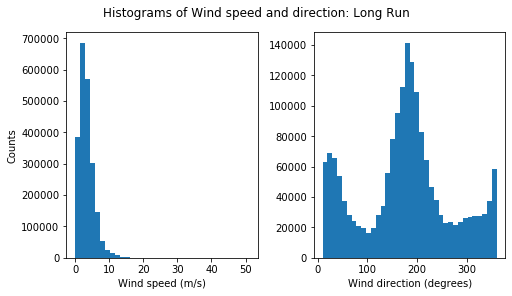

In [32]:
fig, axs = hists(longrun)
fig.suptitle("Histograms of Wind speed and direction: Long Run")
fig.savefig("figures/longrun_hists.png")

Some interesting observations:

* The direction distribution around 180 degrees looks much more symmetric than in the recent/dense case.
* The speed distribution is less skewed toward 0, which will probably make a Weibull fit even more problematic.

In [33]:
longrun_corrs = corrs(longrun)
longrun_corrs[0]

,wind_speed_727920-24227,wind_speed_727930-24233,wind_speed_727935-24234,wind_speed_727970-94240,wind_speed_727976-24217,wind_speed_994350-99999
wind_speed_727920-24227,1.000000,0.502770,0.567639,0.444605,0.495443,0.433958
wind_speed_727930-24233,0.502770,1.000000,0.622741,0.393129,0.399046,0.490639
wind_speed_727935-24234,0.567639,0.622741,1.000000,0.398118,0.447354,0.556521
wind_speed_727970-94240,0.444605,0.393129,0.398118,1.000000,0.453065,0.328668
wind_speed_727976-24217,0.495443,0.399046,0.447354,0.453065,1.000000,0.391868
wind_speed_994350-99999,0.433958,0.490639,0.556521,0.328668,0.391868,1.000000


I note a few interesting things here:

* The R values are slightly higher for these stations than the larger set.
* Seatac (727930) and Boeing Field (727935) have the best correlation, which is not surprising since they are located close together.
* The worst correlations are all with Quillayute Airport, near the Pacific Coast on the other side of the Olympic Penninsula. This station may just be an outlier that is not providing good data representative of Puget Sound.

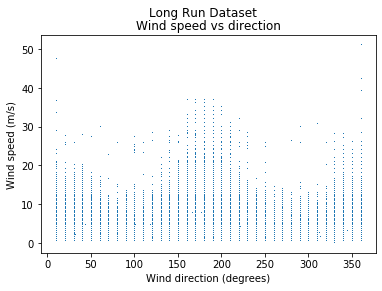

In [34]:
fig, ax = speed_vs_direction(longrun)
fig.suptitle("Long Run Dataset")
fig.savefig("figures/longrun_speed_vs_direction.png")

This plot appears to show that higher wind speeds are more likely coming from the south or north; but since that's where the wind is more likely to be coming from generally, that's not surprising. The recent/dense data earlier did not show the northern spikes.

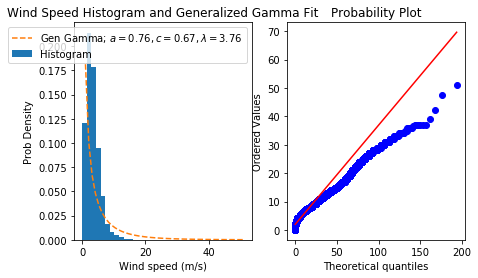

In [35]:
params, fit, axs = gengamma_fit(longrun)
fig.suptitle("Long Run Dataset")
fig.savefig("figures/longrun_gengamma_fit.png")

Wow, the generalized gamma distribution fits this data much better!

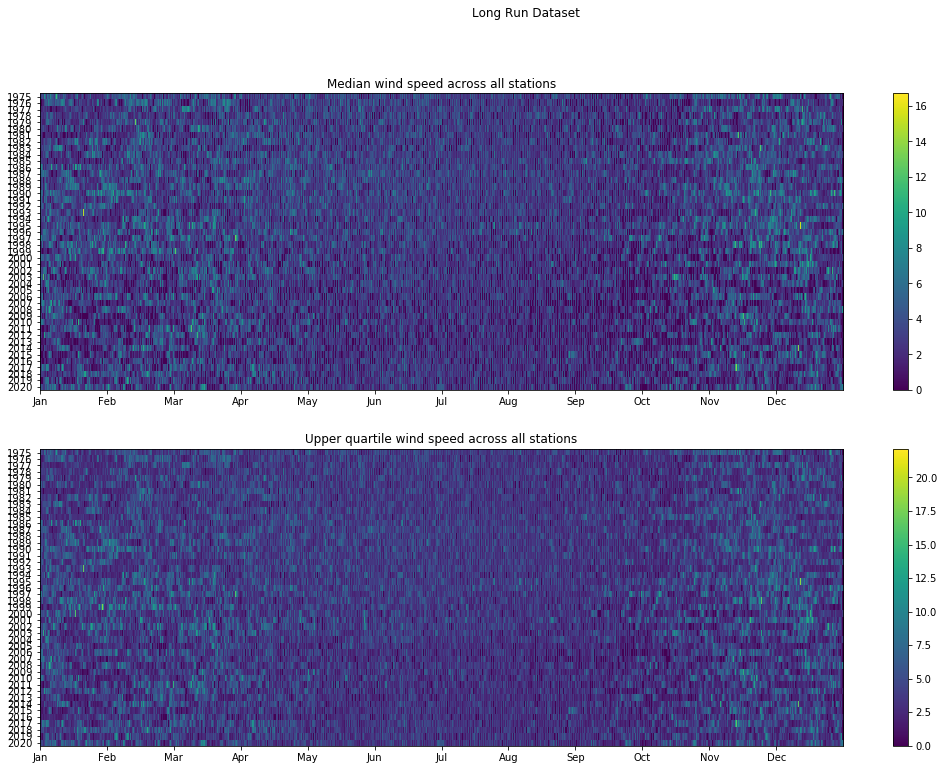

In [36]:
fig, axs = timeseries_per_year(longrun)
fig.suptitle("Long Run Dataset")
fig.savefig("figures/longrun_timeseries_per_year.png")

Expanding the timeline shows a few other wind events of interest in the record:

* High upper quartile speeds in late May or early June of 2000, 2001, and 2002
* Mid-June 1994
* Late July/early August of 1995

It's also quite interesting that all three years modeled in the Salish Sea Model--2006, 2014, and 2016--visually appear to have rather low median and upper quartile winds during the summer. At some future point I may follow up on this quantitatively.

In [37]:
kw_by_year(longrun)

KruskalResult(statistic=28677.812545928908, pvalue=0.0)

As in the recent/dense dataset, individual years are not random subsamples of the same population of wind speeds.

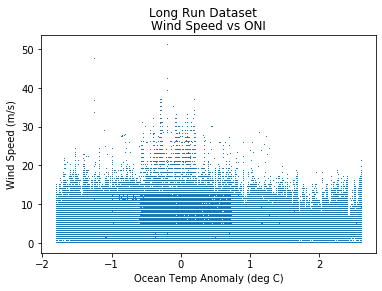

In [38]:
data, fig, ax = correlate(longrun, 'wind_speed', oni_full)
ax.set(title="Wind Speed vs ONI", ylabel="Wind Speed (m/s)", xlabel="Ocean Temp Anomaly (deg C)")
fig.suptitle("Long Run Dataset")
fig.savefig("figures/longrun_corr_oni.png")

While at first glance there appears to be a pattern here, it's probably not significant as ONIs of around 0 are more likely in the historical record. I don't see much that's worth analyzing, at least not without removing the noise.

With this extended dataset, one way around the large seasonal component is to redo this attempted correlation by only considering a single month in the summer.

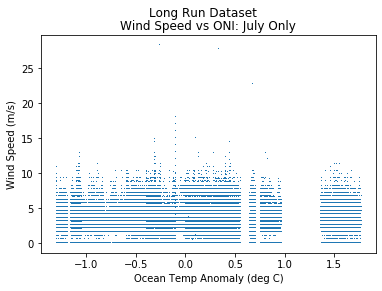

In [39]:
data, fig, ax = correlate(longrun.loc[longrun['date'].dt.month == 7], 'wind_speed', oni_full)
ax.set(title="Wind Speed vs ONI: July Only", ylabel="Wind Speed (m/s)", xlabel="Ocean Temp Anomaly (deg C)")
fig.suptitle("Long Run Dataset")
fig.savefig("figures/longrun_corr_oni_jul.png")

Nope, there still does not appear to be a pattern.

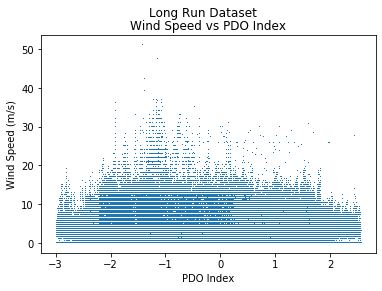

In [40]:
data, fig, ax = correlate(longrun, 'wind_speed', pdo_full)
ax.set(title="Wind Speed vs PDO Index", xlabel="PDO Index", ylabel="Wind Speed (m/s)")
fig.suptitle("Long Run Dataset")
fig.savefig("figures/longrun_corr_pdo.png")

This seems to suggest that large wind speeds are much more common during a specific point in the PDO cycle, around where the index is -1. This could be yet another artifact of there being more data from that time.

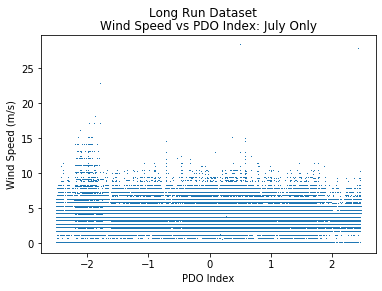

In [41]:
data, fig, ax = correlate(longrun.loc[longrun['date'].dt.month == 7], 'wind_speed', pdo_full)
ax.set(title="Wind Speed vs PDO Index: July Only", xlabel="PDO Index", ylabel="Wind Speed (m/s)")
fig.suptitle("Long Run Dataset")
fig.savefig("figures/longrun_corr_pdo_jul.png")

This is quite preliminary, but it is interesting that there is a cluster of higher wind speeds around a -2 PDO index. This is an extreme Pacific cool phase, which last occurred in 2010-2011. None of the three modeled years in the SSM had PDO indices like this.

None of the candidate years with such low PDO index in July show anomalous upper quartile July wind speeds in the earlier heat map.

Can we isolate this trend by examining just the upper quartile wind speeds?

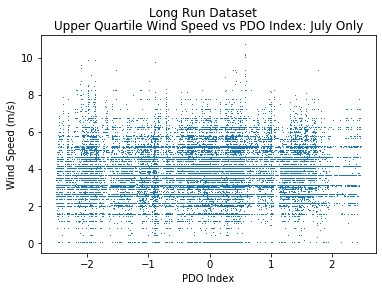

In [42]:
quants = get_station_quantiles(longrun, 'wind_speed')
data, fig, ax = correlate(quants.loc[quants.index.month == 7], 'upperquart', pdo_full)
ax.set(title="Upper Quartile Wind Speed vs PDO Index: July Only", xlabel="PDO Index", ylabel="Wind Speed (m/s)")
fig.suptitle("Long Run Dataset")
fig.savefig("figures/longrun_corr_pdo_jul_upperquart.png")

This makes the pattern disappear. If it's not there at the upper quartile, those speeds at a -2 PDO index must be quite the outliers, and may not be significant to the model.

## Discussion

The predominant wind directions are informative for looking at wind sensitivity of Puget Sound; other directions can be tested but they are not likely to actually be encountered in reality.

Low wind speeds in the summer have potential implications on the significance of wind to Puget Sound water quality. Since Puget Sound is more likely to experience low oxygen conditions during the summer, this suggests that wind is not going to be a major driver of mixing when it would be needed most for water quality. Any model sensitivity to wind would probably just affect performance during the less crucial winter months, although it could potentially assist with flushing nutrients before the summer. Testing the model with low wind speeds during the winter could be informative, even if is not expected to be a condition which is ever encountered.

The wind speeds within Puget Sound from the longest running stations are fairly well correlated with each other. Stations outside this area are poorly correlated. This shows that accurate models of Puget Sound might be able to get away with a single set of wind data as long as the modeling domain is quite restricted. The Salish Sea Model (SSM), however, incorporates a vast modeling domain that includes the Strait of Juan de Fuca, the Strait of Georgia, and parts of the Pacific coast. Winds from Quillayute, on the Pacific Coast, are poorly correlated with the Puget Sound wind data which demonstrates that the SSM should be evaluated with more complete wind data if it is indeed sensitive to winds.

Climate cycle correlations with winds were inconclusive, mainly because of the high wind variability at small time scales and with the annual seasonal cycle. Removing these factors would take much more analysis, though it is possible that one extreme part of the PDO cycle may lead to high winds in the summer.

The calibration years of 2008, 2014, and 2016 look like typical years based on the above heat maps. There are outlier years of wind data, though, which would be worth examining more closely using the SSM. There is also reason to believe, through the Kruskal-Wallis tests, that individual years of wind data are not representative of general conditions, so more testing with data derived from different years could be illuminating.

## Conclusion

In constructing a wind sensitivity analysis of the Puget Sound, I believe I should investigate how the model behaves under the following conditions:

* Separately increase and decrease the wind speeds in the winter and spring months.
* Introduce an anomolously high wind event in the summer like was observed in 1994, 1995, 2000, 2001, 2002, and 2015.
* Separately force the direction of high-speed winds to be from the south and north.
* Use meteorological model data from 2010 or 2011, during the last extreme PDO Pacific cool phase, as inputs to the model for an existing modeled year.

The histograms of wind observations will also be useful to compare against the existing model inputs to see if they generally match. If not, it could indicate either a problem with the meteorological model outputs begin fed into the Salish Sea Model, or it could be a result of comparing land and sea surface winds. Even in the latter case, I would expect at least a decent agreement, and any deviation could be used to design further model runs in which the wind data is adjusted to more closely align with these sample distributions.

Since the Salish Sea Model itself has not yet been evaluated, it is too early to say whether these findings have implications for the existing model. Even if the wind data being used in the model is not representative, it may not matter if the model itself does not respond differently to wind data which is representative. The next step in this process is to conduct a model sensitivity analysis to answer that question.